# Quick start tutorial


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlrun/mlrun/blob/development/docs/tutorial/colab/01-mlrun-basics-colab.ipynb)


**Introduction to MLRun - Use serverless functions to train and deploy models**

This notebook provides a quick overview of developing and deploying machine learning applications using the [MLRun](https://www.mlrun.org/) MLOps orchestration framework.

Tutorial steps:
- [**Install MLRun**](#install)
- [**Define the MLRun project and ML functions**](#define-project)
- [**Run the data processing function and log artifacts**](#run-function)
- [**Use the MLRun built-in Function Hub functions for training**](#use-hub)
- [**Build, test, and deploy model serving functions**](#model-serving)

[**Watch the video tutorial**](https://youtu.be/xI8KVGLlj7Q).

<a id="install"></a>
## Install MLRun

MLRun has a backend service that can run locally or over Kubernetes (preferred). See the instructions for installing it [locally using Docker](https://docs.mlrun.org/en/stable/install/local-docker.html) or [over Kubernetes Cluster](https://docs.mlrun.org/en/latest/install/kubernetes.html). Alternatively, you can use Iguazio's [managed MLRun service](https://www.iguazio.com/docs/latest-release/).

**Before you start, make sure the MLRun client package is installed and configured properly:**

This notebook uses sklearn. If it is not installed in your environment run `!pip install scikit-learn~=1.0`.

In [ ]:
# Install MLRun and sklearn, run this only once (restart the notebook after the install !!!)
%pip install mlrun scikit-learn~=1.0

**Restart the notebook kernel after the pip installation.**

In [2]:
import mlrun

<a id="set-env"></a>
### Configure the client environment

MLRun client connects to the local or remote MLRun service/cluster using a REST API. To configure the service address, credentials, and default settings, you use the `mlrun.set_environment()` method, or environment variables, (see details in [Set up your client environment](https://docs.mlrun.org/en/stable/install/remote.html).)

You can skip this step when using MLRun Jupyter notebooks or Iguazio's managed notebooks.

<a id="define-project"></a>
## Define MLRun project and ML functions

[MLRun **Project**](https://docs.mlrun.org/en/stable/projects/project.html) is a container for all your work on a particular activity or application. Projects host `functions`, `workflow`,
`artifacts`, `secrets`, and more. Projects have access control and can be accessed by one or more users. They are usually associated with a GIT and interact with CI/CD frameworks for automation.
See the MLRun [Projects documentation](https://docs.mlrun.org/en/stable/projects/project.html).

**Create a new project**

In [3]:
project = mlrun.get_or_create_project("quick-tutorial", "./", user_project=True)

> 2022-12-17 19:40:59,554 [info] loaded project quick-tutorial from MLRun DB


[MLRun serverless functions](https://docs.mlrun.org/en/latest/runtimes/functions.html) specify the source code, base `image`, extra package `requirements`, runtime engine `kind` (batch `job`, real-time `serving`, `spark`, `dask`, etc.), and desired resources (cpu, gpu, mem, storage, ..). The runtime engines (local, job, Nuclio, Spark, etc.) automatically transform the function code and spec into fully managed and elastic services that run over Kubernetes.
Function source code can come from a single file (.py, .ipynb, etc.) or a full archive (git, zip, tar). MLRun can execute an entire file/notebook or specific function classes/handlers.

```{admonition} Note
The `@mlrun.handler` is a decorator that logs the returning values to MLRun as configured. This example uses the default settings so that it logs a dataset (`pd.DataFrame`) and a string value by getting the returned objects types. In addition to logging outputs, the decorator can parse incoming inputs to the required type. For more info, see the [`mlrun.handler`](https://docs.mlrun.org/en/latest/api/mlrun.html#mlrun.handler) documentation.
```

**Function code**

Run the following cell to generate the data prep file (or copy it manually):

In [4]:
%%writefile data-prep.py

import pandas as pd
from sklearn.datasets import load_breast_cancer

import mlrun


@mlrun.handler(outputs=["dataset", "label_column"])
def breast_cancer_generator():
    """
    A function which generates the breast cancer dataset
    """
    breast_cancer = load_breast_cancer()
    breast_cancer_dataset = pd.DataFrame(
        data=breast_cancer.data, columns=breast_cancer.feature_names
    )
    breast_cancer_labels = pd.DataFrame(data=breast_cancer.target, columns=["label"])
    breast_cancer_dataset = pd.concat(
        [breast_cancer_dataset, breast_cancer_labels], axis=1
    )

    return breast_cancer_dataset, "label"

Writing data-prep.py


**Create a serverless function object from the code above, and register it in the project**

In [5]:
data_gen_fn = project.set_function("data-prep.py", name="data-prep", kind="job", image="mlrun/mlrun", handler="breast_cancer_generator")
project.save()  # save the project with the latest config

<a id="run-function"></a>
## Run your data processing function and log artifacts
Functions are executed (using the CLI or SDK **`run`** command) with an optional `handler`, various `params`, `inputs`, and resource requirements. This generates a `run` object that can be tracked through the CLI, UI, and SDK. Multiple functions can be executed and tracked as part of a multi-stage pipeline (workflow). 

```{admonition} Note
When a function has additional package `requirements`, or needs to include the content of a `source` archive,
you must first build the function using the `project.build_function()` method.
```

The `local` flag indicates if the function is executed **locally** or "teleported" and executed in the **Kubernetes cluster**. The execution progress and results can be viewed in the UI (see hyperlinks below).

<br>

**Run using the SDK**

In [6]:
gen_data_run = project.run_function("data-prep", local=True)

> 2022-12-17 19:41:00,005 [info] starting run data-prep-breast_cancer_generator uid=2593e9d01d854e21b1cb954c7fa481b7 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
quick-tutorial-dani,...7fa481b7,0,Dec 17 19:41:00,completed,data-prep-breast_cancer_generator,v3io_user=danikind=owner=danihost=jupyter-dani-57fb4cf8d5-pqn4x,,,label_column=label,dataset


> 2022-12-17 19:41:12,858 [info] run executed, status=completed


<br>

**Print the run state and outputs**

In [7]:
gen_data_run.state()

'completed'

In [8]:
gen_data_run.outputs

{'label_column': 'label',
 'dataset': 'store://artifacts/quick-tutorial-dani/data-prep-breast_cancer_generator_dataset:2593e9d01d854e21b1cb954c7fa481b7'}

<br>

**Print the output dataset artifact (`DataItem` object) as dataframe**

In [9]:
gen_data_run.artifact("dataset").as_df().head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<a id="use-hub"></a>
## Train a model using an MLRun built-in Function Hub

MLRun provides a [**Function Hub**](https://www.mlrun.org/marketplace/) that hosts a set of pre-implemented and
validated ML, DL, and data processing functions.

You can import the `auto-trainer` hub function that can: train an ML model using a variety of ML frameworks; generate
various metrics and charts; and log the model along with its metadata into the MLRun model registry.

In [10]:
# Import the function
trainer = mlrun.import_function('hub://auto_trainer')


See the `auto_trainer` function usage instructions in [the Function Hub](https://www.mlrun.org/marketplace/functions/master/auto_trainer/) or by typing `trainer.doc()`

**Run the function on the cluster (if there is)**

In [11]:
trainer_run = project.run_function(trainer,
    inputs={"dataset": gen_data_run.outputs["dataset"]},
    params = {
        "model_class": "sklearn.ensemble.RandomForestClassifier",
        "train_test_split_size": 0.2,
        "label_columns": "label",
        "model_name": 'cancer',
    }, 
    handler='train',
)

> 2022-12-17 19:41:15,770 [info] starting run auto-trainer-train uid=55f371a9ffef4515b5df723ac11192a2 DB=http://mlrun-api:8080
> 2022-12-17 19:41:16,057 [info] Job is running in the background, pod: auto-trainer-train-48mj8
> 2022-12-17 19:41:20,807 [info] Sample set not given, using the whole training set as the sample set
> 2022-12-17 19:41:21,069 [info] training 'cancer'
> 2022-12-17 19:41:22,916 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 55f371a9ffef4515b5df723ac11192a2 -p quick-tutorial-dani', 'logs_cmd': 'mlrun logs 55f371a9ffef4515b5df723ac11192a2 -p quick-tutorial-dani'}
> 2022-12-17 19:41:22,916 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.vmdev94.lab.iguazeng.com/mlprojects/quick-tutorial-dani/jobs/monitor/55f371a9ffef4515b5df723ac11192a2/overview'}
> 2022-12-17 19:41:22,917 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
quick-tutorial-dani,...c11192a2,0,Dec 17 19:41:20,completed,auto-trainer-train,v3io_user=danikind=jobowner=danimlrun/client_version=1.2.1-rc4host=auto-trainer-train-48mj8,dataset,model_class=sklearn.ensemble.RandomForestClassifiertrain_test_split_size=0.2label_columns=labelmodel_name=cancer,accuracy=0.9649122807017544f1_score=0.971830985915493precision_score=0.9583333333333334recall_score=0.9857142857142858,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2022-12-17 19:41:25,430 [info] run executed, status=completed


<br>

**View the job progress results and the selected run in the MLRun UI**

![train job in UI](../_static/images/tutorial/train-job.png)


<br>

**Results (metrics) and artifacts are generated and tracked automatically by MLRun**

In [12]:
trainer_run.outputs

{'accuracy': 0.9649122807017544,
 'f1_score': 0.971830985915493,
 'precision_score': 0.9583333333333334,
 'recall_score': 0.9857142857142858,
 'feature-importance': 'v3io:///projects/quick-tutorial-dani/artifacts/auto-trainer-train/0/feature-importance.html',
 'test_set': 'store://artifacts/quick-tutorial-dani/auto-trainer-train_test_set:55f371a9ffef4515b5df723ac11192a2',
 'confusion-matrix': 'v3io:///projects/quick-tutorial-dani/artifacts/auto-trainer-train/0/confusion-matrix.html',
 'roc-curves': 'v3io:///projects/quick-tutorial-dani/artifacts/auto-trainer-train/0/roc-curves.html',
 'calibration-curve': 'v3io:///projects/quick-tutorial-dani/artifacts/auto-trainer-train/0/calibration-curve.html',
 'model': 'store://artifacts/quick-tutorial-dani/cancer:55f371a9ffef4515b5df723ac11192a2'}

In [ ]:
# Display HTML output artifacts
trainer_run.artifact('confusion-matrix').show()

<a id="model-serving"></a>
## Build, test, and deploy the model serving functions

MLRun serving can produce managed, real-time, serverless, pipelines composed of various data processing and ML tasks. The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere. For more details and examples, see [MLRun serving graphs](https://docs.mlrun.org/en/stable/serving/serving-graph.html).

**Create a model serving function**

In [14]:
serving_fn = mlrun.new_function("serving", image="python:3.8", kind="serving", requirements=["mlrun[complete]", "scikit-learn==1.1.2"])

**Add a model**

The basic serving topology supports a router with multiple child models attached to it.
The `function.add_model()` method allows you to add models and specify the `name`, `model_path` (to a model file, dir, or artifact), and the serving `class` (built-in or user defined).

In [15]:
serving_fn.add_model('cancer-classifier',model_path=trainer_run.outputs["model"], class_name='mlrun.frameworks.sklearn.SklearnModelServer')

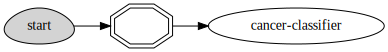

In [24]:
# Plot the serving graph topology
serving_fn.spec.graph.plot(rankdir="LR")

**Simulating the model server locally**

In [17]:
# Create a mock (simulator of the real-time function)
server = serving_fn.to_mock_server()

> 2022-12-17 19:41:36,296 [warning] run command, file or code were not specified
> 2022-12-17 19:41:39,031 [info] model cancer-classifier was loaded
> 2022-12-17 19:41:39,032 [info] Loaded ['cancer-classifier']


<br>

**Test the mock model server endpoint**
    
- List the served models

In [18]:
server.test("/v2/models/", method="GET")

{'models': ['cancer-classifier']}

- Infer using test data

In [19]:
my_data = {"inputs"
           :[[
               1.371e+01, 2.083e+01, 9.020e+01, 5.779e+02, 1.189e-01, 1.645e-01,
               9.366e-02, 5.985e-02, 2.196e-01, 7.451e-02, 5.835e-01, 1.377e+00,
               3.856e+00, 5.096e+01, 8.805e-03, 3.029e-02, 2.488e-02, 1.448e-02,
               1.486e-02, 5.412e-03, 1.706e+01, 2.814e+01, 1.106e+02, 8.970e+02,
               1.654e-01, 3.682e-01, 2.678e-01, 1.556e-01, 3.196e-01, 1.151e-01]
            ]
}
server.test("/v2/models/cancer-classifier/infer", body=my_data)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


{'id': '53c8ca48683647428f6baf45fe6a2d7e',
 'model_name': 'cancer-classifier',
 'outputs': [0]}

- Read the model name, ver and schema (input and output features)

**Deploy a real-time serving function (over Kubernetes or Docker)**

This section requires Nuclio to be installed (over k8s or Docker).

Use the mlrun `deploy_function()` method to build and deploy a Nuclio serving function from your serving-function code.
You can deploy the function object (`serving_fn`) or reference pre-registered project functions.

In [20]:
project.deploy_function(serving_fn)

> 2022-12-17 19:41:46,151 [info] Starting remote function deploy
2022-12-17 19:41:46  (info) Deploying function
2022-12-17 19:41:46  (info) Building
2022-12-17 19:41:46  (info) Staging files and preparing base images
2022-12-17 19:41:46  (info) Building processor image
2022-12-17 19:49:21  (info) Build complete
2022-12-17 19:50:39  (info) Function deploy complete
> 2022-12-17 19:50:39,236 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-quick-tutorial-dani-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['quick-tutorial-dani-serving-quick-tutorial-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}


DeployStatus(state=ready, outputs={'endpoint': 'http://quick-tutorial-dani-serving-quick-tutorial-dani.default-tenant.app.vmdev94.lab.iguazeng.com/', 'name': 'quick-tutorial-dani-serving'})

- Test the live endpoint

In [21]:
serving_fn.invoke("/v2/models/cancer-classifier/infer", body=my_data)

> 2022-12-17 19:50:39,305 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-quick-tutorial-dani-serving.default-tenant.svc.cluster.local:8080/v2/models/cancer-classifier/infer'}


{'id': 'b5d934ac-cec0-4a78-94ae-0b7da4733581',
 'model_name': 'cancer-classifier',
 'outputs': [0]}

## Done!

Congratulation! You've completed Part 1 of the MLRun getting-started tutorial.
Proceed to [**Part 2: Train, Track, Compare, and Register Models**](02-model-training.html) to learn how to train an ML model.